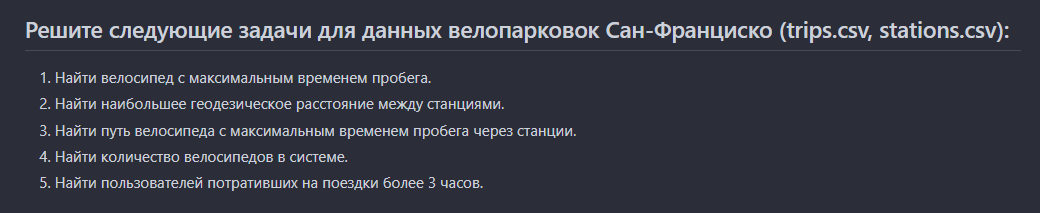

In [23]:
!python3 -m venv venv
!source venv/bin/activate 
!python3 -m pip install numpy

Defaulting to user installation because normal site-packages is not writeable


In [24]:
!python --version

Python 3.9.5


In [3]:
from pyspark import SparkContext, SparkConf 
conf = SparkConf().setAppName("laba 1 Gorelykh").setMaster('yarn')

In [4]:
sc = SparkContext.getOrCreate(conf=conf)

In [5]:
tripData = sc.textFile("data/trips.csv")

tripsHeader = tripData.first()
trips = tripData.filter(lambda row: row != tripsHeader).map(lambda row: row.split(",", -1))

In [342]:
trips.count()

669959

In [7]:
trips.take(2)

[['4576',
  '63',
  '',
  'South Van Ness at Market',
  '66',
  '8/29/2013 14:14',
  'South Van Ness at Market',
  '66',
  '520',
  'Subscriber',
  '94127'],
 ['4607',
  '',
  '8/29/2013 14:42',
  'San Jose City Hall',
  '10',
  '8/29/2013 14:43',
  'San Jose City Hall',
  '10',
  '661',
  'Subscriber',
  '95138']]

In [8]:
from typing import NamedTuple
from datetime import datetime

def initTrip(trips):
    class Trip(NamedTuple):
        trip_id: int
        duration: int
        start_date: datetime
        start_station_name: str
        start_station_id: int
        end_date: datetime
        end_station_name: str
        end_station_id: int
        bike_id: int
        subscription_type: str
        zip_code: str
        
    for trip in trips:
        try:
            yield Trip(                             
             trip_id = int(trip[0]),
             duration = int(trip[1]),
             start_date = datetime.strptime(trip[2], '%m/%d/%Y %H:%M'),
             start_station_name = trip[3],
             start_station_id = int(trip[4]),
             end_date = datetime.strptime(trip[5], '%m/%d/%Y %H:%M'),
             end_station_name = trip[6],
             end_station_id = trip[7],
             bike_id = int(trip[8]),
             subscription_type = trip[9],
             zip_code = trip[10]
            ) 
        except:
            pass

In [150]:
tripsInternal = trips.mapPartitions(initTrip)
tripsInternal.take(2)

[Trip(trip_id=4130, duration=71, start_date=datetime.datetime(2013, 8, 29, 10, 16), start_station_name='Mountain View City Hall', start_station_id=27, end_date=datetime.datetime(2013, 8, 29, 10, 17), end_station_name='Mountain View City Hall', end_station_id='27', bike_id=48, subscription_type='Subscriber', zip_code='97214'),
 Trip(trip_id=4251, duration=77, start_date=datetime.datetime(2013, 8, 29, 11, 29), start_station_name='San Jose City Hall', start_station_id=10, end_date=datetime.datetime(2013, 8, 29, 11, 30), end_station_name='San Jose City Hall', end_station_id='10', bike_id=26, subscription_type='Subscriber', zip_code='95060')]

In [312]:
trips_by_bike_id = tripsInternal.keyBy(lambda trip: trip.bike_id)
trips_by_bike_id.take(1)

[(48,
  Trip(trip_id=4130, duration=71, start_date=datetime.datetime(2013, 8, 29, 10, 16), start_station_name='Mountain View City Hall', start_station_id=27, end_date=datetime.datetime(2013, 8, 29, 10, 17), end_station_name='Mountain View City Hall', end_station_id='27', bike_id=48, subscription_type='Subscriber', zip_code='97214'))]

1. Найти велосипед с максимальным временем пробега.

In [313]:
trips_by_duration = trips_by_bike_id.mapValues(lambda trip: trip.duration)

In [314]:
%%time
m = t.groupByKey().mapValues(sum).top(1, key=lambda x: x[1])[0]
print("Max of duration:", m[1])

Max of duration: 17270400
CPU times: user 36.5 ms, sys: 0 ns, total: 36.5 ms
Wall time: 18.6 s


2. Найти наибольшее геодезическое расстояние между станциями.

In [315]:
def initStation(stations):
    class Station(NamedTuple):
        station_id: int
        name: str
        lat: float
        long: float
        dockcount: int
        landmark: str
        installation: str
    
    for station in stations:
        yield Station(
            station_id = int(station[0]),
            name = station[1],
            lat = float(station[2]),
            long = float(station[3]),
            dockcount = int(station[4]),
            landmark = station[5],
            installation = datetime.strptime(station[6], '%m/%d/%Y')
        )

In [316]:
station_data = sc.textFile("/data/stations.csv")

stationsHeader = station_data.first()
stations = station_data.filter(lambda row: row != stationsHeader).map(lambda row: row.split(",", -1))

In [341]:
stationsInternal = stations.mapPartitions(initStation)

In [206]:
l = stationsInternal.map(lambda row: row.long)
l.max()

-121.877349

3. Найти путь велосипеда с максимальным временем пробега через станции.

In [207]:
m = t.groupByKey().mapValues(sum).top(1, key=lambda x: x[1])

[(568474, 17270400)]

In [227]:
trip = tripsInternal.filter(lambda x: x.trip_id == m[0][0])

In [284]:
start = trip.map(lambda x: int(x.start_station_id))
stop = trip.map(lambda x: int(x.end_station_id))

stations_ = sc.union([start, stop]) 

In [285]:
stations_.count()

2

In [286]:
stations_ = stations_.collect()
stations_

[66, 62]

In [276]:
station = stationsInternal.filter(lambda row: any(row.station_id == x for x in stations_))

In [280]:
station.count()

2

In [287]:
station.collect()

[Station(station_id=62, name='2nd at Folsom', lat=37.785299, long=-122.39623600000002, dockcount=19, landmark='San Francisco', installation=datetime.datetime(2013, 8, 22, 0, 0)),
 Station(station_id=66, name='South Van Ness at Market', lat=37.774814, long=-122.418954, dockcount=19, landmark='San Francisco', installation=datetime.datetime(2013, 8, 23, 0, 0))]

4. Найти количество велосипедов в системе.

In [308]:
bikes = tripsInternal.map(lambda row: row.bike_id).distinct()

In [310]:
bikes.count()

700

5. Найти пользователей потративших на поездки более 3 часов.

In [338]:
trips_by_trip_id = tripsInternal.keyBy(lambda trip: trip.trip_id)

In [333]:
trips_by_duration_more_3_hours = trips_by_trip_id.mapValues(lambda trip: trip.duration).filter(lambda trip: trip[1] > 3*60*60)

In [339]:
trips_by_duration_more_3_hours.collect()

[(4639, 11118),
 (4637, 11272),
 (4528, 12280),
 (4363, 15244),
 (4193, 18192),
 (4190, 18240),
 (4225, 21612),
 (4663, 52698),
 (4532, 84990),
 (4521, 85385),
 (5069, 86102),
 (4505, 97713),
 (5539, 10805),
 (6032, 10963),
 (6409, 12408),
 (6408, 12459),
 (5697, 12562),
 (5683, 12875),
 (5218, 13809),
 (5716, 14545),
 (5717, 14568),
 (5241, 15160),
 (5537, 16570),
 (5253, 16713),
 (5531, 16744),
 (6131, 16933),
 (6098, 17593),
 (6091, 17774),
 (5115, 18198),
 (5114, 18206),
 (5250, 18219),
 (5249, 18241),
 (5508, 20920),
 (5506, 20931),
 (5167, 23182),
 (5166, 23212),
 (5640, 23319),
 (5638, 23360),
 (6003, 23694),
 (5380, 25335),
 (5222, 27103),
 (5120, 33088),
 (5113, 34449),
 (5182, 36255),
 (6412, 70731),
 (6178, 70982),
 (6462, 77919),
 (5493, 83224),
 (6282, 241334),
 (7069, 11161),
 (6626, 11632),
 (6963, 11642),
 (7074, 11653),
 (6962, 11675),
 (7067, 11825),
 (6792, 11964),
 (7143, 12303),
 (6613, 12400),
 (7176, 12818),
 (7081, 14180),
 (7079, 14299),
 (7021, 14451),
 (7016,